##### NOTE:
1. Ensure ComprehendFullAccess Policy has been attached to the IAM Role that SageMaker uses
2. Ensure SageMaker has access to the S3 Bucket defined in 'DATA_BUCKET' below, and has an appropriate S3 Policy (e.g. AmazonS3FullAccess) attached to the IAM Role that SageMaker uses

In [1]:
import pandas as pd
from collections import OrderedDict
import requests
from sklearn import metrics
import boto3

In [19]:
REGION = 'us-east-1'

DATA_ACCESS_ROLE_ARN = 'arn:aws:iam::590808818194:role/service-role/AmazonSageMaker-ExecutionRole-20190109T112988'
DATA_BUCKET = 'svn-handson-ml-comprehend'
IMDB_DATA_PREFIX = 'imdb-dataset.csv'
TOPICS_OUTPUT_PREFIX = 'imdb-topics'

SAMPLE_SIZE = 1000
MAX_TEXT_LENGTH = 4900
BATCH_SIZE = 25
PREDICTION_THRESHOLD = 0.5

##### Get a client to access the AWS Comprehend API

In [3]:
comprehend = boto3.client('comprehend', region_name=REGION)

##### Sample sentence to demonstrate key Comprehend functionalities

In [4]:
sample_sentence = "It’s always a great day when I can randomly put my equestrian knowledge to good use at work! #AWS #BePeculiar"

##### Key phrase detection

In [5]:
phrases = comprehend.detect_key_phrases(Text=sample_sentence, LanguageCode='en')
for phrase in phrases['KeyPhrases']:
    print(phrase)

{'Score': 0.9999999403953552, 'Text': 'a great day', 'BeginOffset': 12, 'EndOffset': 23}
{'Score': 1.0, 'Text': 'my equestrian knowledge', 'BeginOffset': 48, 'EndOffset': 71}
{'Score': 0.9999207258224487, 'Text': 'good use', 'BeginOffset': 75, 'EndOffset': 83}
{'Score': 0.9999996423721313, 'Text': 'work', 'BeginOffset': 87, 'EndOffset': 91}


##### Named Entity Recognition

In [6]:
entities = comprehend.detect_entities(Text=sample_sentence, LanguageCode='en')
for entity in entities['Entities']:
    print(entity)

{'Score': 0.6978814601898193, 'Type': 'TITLE', 'Text': '#AWS', 'BeginOffset': 93, 'EndOffset': 97}


##### Sentiment Analysis

In [7]:
sentiment = comprehend.detect_sentiment(Text=sample_sentence, LanguageCode='en')
print(sentiment['SentimentScore'])

{'Positive': 0.9861279726028442, 'Negative': 0.0001362226321361959, 'Neutral': 0.013735050335526466, 'Mixed': 6.885450147819938e-07}


##### Read IMDB dataset from S3 into a pandas dataframe

In [8]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=DATA_BUCKET, Key=IMDB_DATA_PREFIX)

df = pd.read_csv(obj['Body'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


##### Alternative method of reading dataset to dataframe

In [9]:
# df = pd.read_csv('s3://svn-handson-ml-comprehend/imdb-dataset.csv')

##### Detecting sentiment of one review

In [10]:
import random as rand

review_number = rand.randint(1,len(df))

sample_review_object = df.iloc[review_number, ]
sample_review_text = sample_review_object['review']

sample_review_sentiment = comprehend.detect_sentiment(Text=sample_review_text, LanguageCode='en')

print(f"Review: {review_number}\n\n\
Review Text: {sample_review_text}\n\n\
Predicted sentiment: {sample_review_sentiment['SentimentScore']},\n\n\
Actual sentiment: {sample_review_object['sentiment']}")

Review: 24884

Review Text: I have seen this movie and even though I kind of knew who the killer was from the beginning I still liked watching it. I would recommend it to other people. It comes on Lifetime movie network quite a lot. And I am thinking since it's close to Halloween they might play it more. So please be on the look out for it if you are interested in watching it. I believe that Alicia Silverstone played her part very well. I really like her as an actress and person. She seems so nice and down to earth. Kevin Dillon he's performance was so so for me. I am not trying to knock him or anything but I believe that his brother Matt would have been able to pull this bad evil serial killer persona better. Kevin just seems too sweet for me. But I think he did okay.

Predicted sentiment: {'Positive': 0.9948318004608154, 'Negative': 0.0011038831435143948, 'Neutral': 0.004045231267809868, 'Mixed': 1.911084291350562e-05},

Actual sentiment: positive


##### Detecting sentiment of a batch of texts: Preprocessing

In [11]:
df_sample = df.head(n=SAMPLE_SIZE).copy()
df_sample['label'] = df_sample['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df_sample['review_processed'] = df_sample['review'].apply(lambda x: x[:MAX_TEXT_LENGTH])

##### Detecting sentiment of each batch

In [12]:
batch_size = BATCH_SIZE
max_batch_index = SAMPLE_SIZE // batch_size
results = []

for batch_index in range(max_batch_index):
    if batch_index % 5 == 0:
        print(f"Processing batch {batch_index}")
        
    batch_text_list = df_sample.iloc[batch_index*BATCH_SIZE:batch_index*BATCH_SIZE + batch_size,:]['review_processed'].tolist()
    results.extend(comprehend.batch_detect_sentiment(TextList=batch_text_list, LanguageCode='en')['ResultList'])

Processing batch 0
Processing batch 5
Processing batch 10
Processing batch 15
Processing batch 20
Processing batch 25
Processing batch 30
Processing batch 35


##### Creating `sentiment_pred` column in DataFrame by using the 'Positive' scores reported

In [13]:
df_sample['sentiment_pred'] = pd.Series([result['SentimentScore']['Positive'] for result in results])

##### Sanity Check

In [14]:
df_sample[['review', 'label', 'sentiment_pred']].head(n=10)

,review,label,sentiment_pred
0,One of the other reviewers has mentioned that ...,1,0.965475
1,A wonderful little production. <br /><br />The...,1,0.998547
2,I thought this was a wonderful way to spend ti...,1,0.815299
3,Basically there's a family where a little boy ...,0,0.454442
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,0.987859
5,"Probably my all-time favorite movie, a story o...",1,0.996241
6,I sure would like to see a resurrection of a u...,1,0.902598
7,"This show was an amazing, fresh & innovative i...",0,0.014710
8,Encouraged by the positive comments about this...,0,0.014309
9,If you like original gut wrenching laughter yo...,1,0.999517


##### Calculating accuracy metrics: AUC

In [15]:
true_values = df_sample['label']
predicted_values = df_sample['sentiment_pred']

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(true_values, predicted_values, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.8867475469901879


##### Plot ROC curve

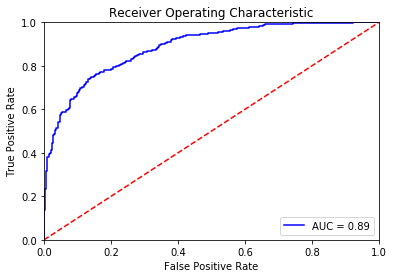

In [24]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Calculating accuracy metrics: Precision and Recall

In [17]:
predicted_values_binary = df_sample['sentiment_pred'].apply(lambda x: 1 if x > 0.5 else 0)

print(f"Precision: {metrics.precision_score(true_values, predicted_values_binary)},\n\
Recall: {metrics.recall_score(true_values, predicted_values_binary)}") 

Precision: 0.8082474226804124,
Recall: 0.782435129740519


##### Topic Detection

In [20]:
# Start topics detection job setting
input_s3_url = "s3://" + DATA_BUCKET + "/" + IMDB_DATA_PREFIX
input_doc_format = "ONE_DOC_PER_LINE"
output_s3_url = "s3:/" + DATA_BUCKET + "/" + TOPICS_OUTPUT_PREFIX

data_access_role_arn = DATA_ACCESS_ROLE_ARN
number_of_topics = 10
job_name = "IMDB_Topic_Modelling_Job"

input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}
output_data_config = {"S3Uri": output_s3_url}

# Starts an asynchronous topic detection job.
response = comprehend.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                 InputDataConfig=input_data_config,
                                                 OutputDataConfig=output_data_config,
                                                 DataAccessRoleArn=data_access_role_arn,
                                                 JobName=job_name)

# Gets job_id
job_id = response["JobId"]
print('job_id: ' + job_id)

# It loops until JobStatus becomes 'COMPLETED' or 'FAILED'.
while True:
    result = comprehend.describe_topics_detection_job(JobId=job_id)
    job_status = result["TopicsDetectionJobProperties"]["JobStatus"]

    if job_status in ['COMPLETED', 'FAILED']:
        print("job_status: " + job_status)
        break
    else:
        print("job_status: " + job_status)
        time.sleep(60)

ClientError: An error occurred (AccessDeniedException) when calling the StartTopicsDetectionJob operation: User: arn:aws:sts::590808818194:assumed-role/AmazonSageMaker-ExecutionRole-20190109T112988/SageMaker is not authorized to perform: iam:PassRole on resource: arn:aws:iam::590808818194:role/service-role/AmazonSageMaker-ExecutionRole-20190109T112988

In [ ]:
# https://docs.aws.amazon.com/es_es/comprehend/latest/dg/get-started-topics.html
import boto3
import json
from bson import json_util
 
comprehend = boto3.client(service_name='comprehend', region_name='region')
                
input_s3_url = "s3://input bucket/input path"
input_doc_format = "ONE_DOC_PER_FILE"
output_s3_url = "s3://output bucket/output path"
data_access_role_arn = "arn:aws:iam::account ID:role/data access role"
number_of_topics = 10
 
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}
output_data_config = {"S3Uri": output_s3_url}
 
start_topics_detection_job_result = comprehend.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=data_access_role_arn)
 
print('start_topics_detection_job_result: ' + json.dumps(start_topics_detection_job_result))
 
job_id = start_topics_detection_job_result["JobId"]
 
print('job_id: ' + job_id)
 
describe_topics_detection_job_result = comprehend.describe_topics_detection_job(JobId=job_id)
 
print('describe_topics_detection_job_result: ' + json.dumps(describe_topics_detection_job_result, default=json_util.default))
 
list_topics_detection_jobs_result = comprehend.list_topics_detection_jobs()
 
print('list_topics_detection_jobs_result: ' + json.dumps(list_topics_detection_jobs_result, default=json_util.default))